In [1]:
!pip3 install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import wandb
wandb.login(key='fac5cd7f576f5d6d2591b0e77385c09a7922b210')
wandb.init(
    # set the wandb project where this run will be logged
    project="CNN_Hyperparameter_Tuning",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.04,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: swayamagrawal1004. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/swayam/.netrc


/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/swayam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


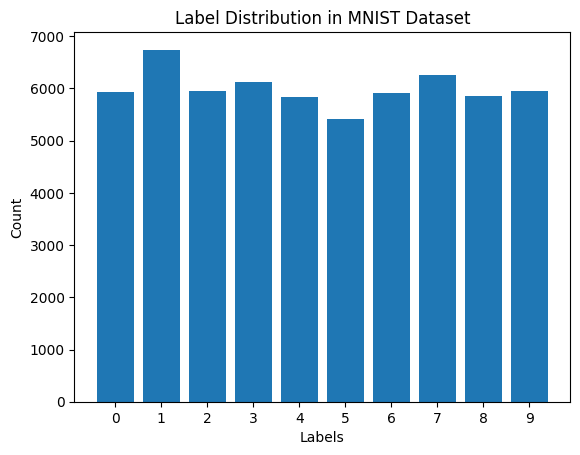

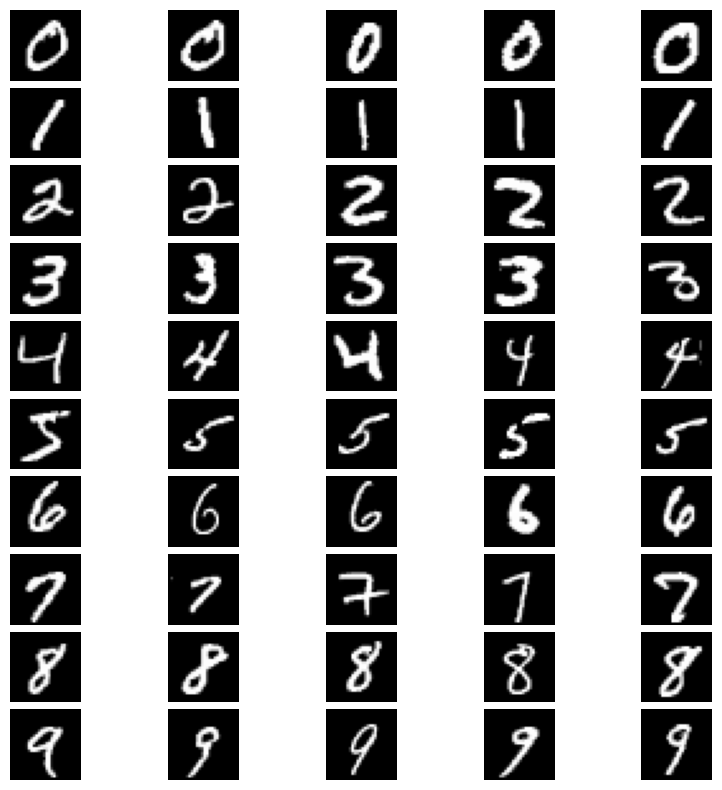

Class imbalance ratio: 1.243681977494927


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set seed for reproducibility
torch.manual_seed(0)

# 4.1.1 - Draw a graph that shows the distribution of labels in the dataset
def plot_label_distribution(dataset):
    label_counts = [0] * 10
    for _, label in dataset:
        label_counts[label] += 1

    labels = [str(i) for i in range(10)]
    plt.bar(labels, label_counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution in MNIST Dataset')
    plt.show()

# 4.1.2 - Visualize several samples (say 5) of images from each class
def visualize_samples(dataset):
    sample_images = [[] for _ in range(10)]
    
    for i, (image, label) in enumerate(dataset):
        if len(sample_images[label]) < 5:
            # Squeeze the image to remove the single channel dimension
            image = image.squeeze().numpy()
            sample_images[label].append(image)

    fig, axs = plt.subplots(10, 5, figsize=(10, 10))
    for i in range(10):
        for j in range(5):
            axs[i, j].imshow(sample_images[i][j], cmap='gray')
            axs[i, j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# 4.1.3 - Check for any class imbalance and report
def check_class_imbalance(dataset):
    label_counts = [0] * 10
    for _, label in dataset:
        label_counts[label] += 1

    min_count = min(label_counts)
    max_count = max(label_counts)
    imbalance_ratio = max_count / min_count

    return imbalance_ratio

# 4.1.4 - Partition the dataset into train, validation, and test sets
def partition_dataset(dataset, train_ratio=0.6, val_ratio=0.2):
    total_len = len(dataset)
    train_len = int(train_ratio * total_len)
    val_len = int(val_ratio * total_len)
    test_len = total_len - train_len - val_len

    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset, [train_len, val_len, test_len])

    return train_set, val_set, test_set

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

plot_label_distribution(mnist_dataset)

visualize_samples(mnist_dataset)

imbalance_ratio = check_class_imbalance(mnist_dataset)
print(f'Class imbalance ratio: {imbalance_ratio}')

train_set, val_set, test_set = partition_dataset(mnist_dataset)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def setKernel(self, kernelsize):
        self.kernelsize = kernelsize
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=kernelsize, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernelsize, stride=1, padding=1)

    def setStride(self, stride):
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=self.kernelsize, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernelsize, stride=stride, padding=1)

    def setDropout(self, dropout):
        self.dropout = nn.Dropout(dropout)
    
    def setBatchSize(self, n):
        self.batch_size = n

    def setLearningRate(self, n):
        self.learning_rate = n

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0

        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_accuracy, "Val Loss": val_loss, "Val Accuracy": val_accuracy})

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_acc, val_acc

/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/swayam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/10 - Train Loss: 0.2083, Train Acc: 93.66%, Val Loss: 0.0649, Val Acc: 97.92%
Epoch 2/10 - Train Loss: 0.0660, Train Acc: 97.94%, Val Loss: 0.0406, Val Acc: 98.72%
Epoch 3/10 - Train Loss: 0.0468, Train Acc: 98.48%, Val Loss: 0.0360, Val Acc: 98.74%
Epoch 4/10 - Train Loss: 0.0396, Train Acc: 98.75%, Val Loss: 0.0318, Val Acc: 98.87%
Epoch 5/10 - Train Loss: 0.0321, Train Acc: 98.98%, Val Loss: 0.0288, Val Acc: 99.16%
Epoch 6/10 - Train Loss: 0.0277, Train Acc: 99.11%, Val Loss: 0.0280, Val Acc: 99.13%
Epoch 7/10 - Train Loss: 0.0250, Train Acc: 99.15%, Val Loss: 0.0265, Val Acc: 99.17%
Epoch 8/10 - Train Loss: 0.0205, Train Acc: 99.32%, Val Loss: 0.0257, Val Acc: 99.15%
Epoch 9/10 - Train Loss: 0.0192, Train Acc: 99.37%, Val Loss: 0.0252, Val Acc: 99.16%
Epoch 10/10 - Train Loss: 0.0170, Train Acc: 99.48%, Val Loss: 0.0276, Val Acc: 99.21%


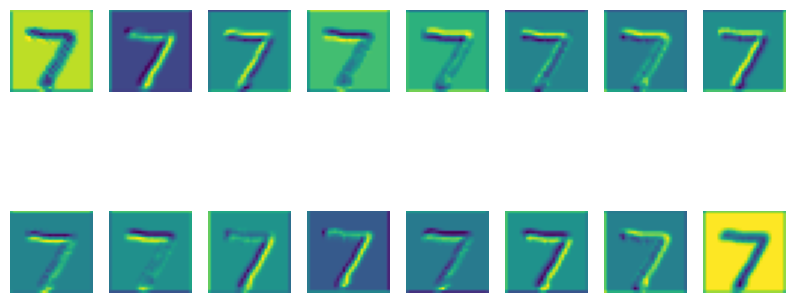

Epoch 1 - Train Loss: 0.2083, Train Accuracy: 93.66%, Val Loss: 0.0649, Val Accuracy: 97.92%
Epoch 2 - Train Loss: 0.0660, Train Accuracy: 97.94%, Val Loss: 0.0406, Val Accuracy: 98.72%
Epoch 3 - Train Loss: 0.0468, Train Accuracy: 98.48%, Val Loss: 0.0360, Val Accuracy: 98.74%
Epoch 4 - Train Loss: 0.0396, Train Accuracy: 98.75%, Val Loss: 0.0318, Val Accuracy: 98.87%
Epoch 5 - Train Loss: 0.0321, Train Accuracy: 98.98%, Val Loss: 0.0288, Val Accuracy: 99.16%
Epoch 6 - Train Loss: 0.0277, Train Accuracy: 99.11%, Val Loss: 0.0280, Val Accuracy: 99.13%
Epoch 7 - Train Loss: 0.0250, Train Accuracy: 99.15%, Val Loss: 0.0265, Val Accuracy: 99.17%
Epoch 8 - Train Loss: 0.0205, Train Accuracy: 99.32%, Val Loss: 0.0257, Val Accuracy: 99.15%
Epoch 9 - Train Loss: 0.0192, Train Accuracy: 99.37%, Val Loss: 0.0252, Val Accuracy: 99.16%
Epoch 10 - Train Loss: 0.0170, Train Accuracy: 99.48%, Val Loss: 0.0276, Val Accuracy: 99.21%


In [4]:
# Load MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_val = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=64, shuffle=False)

# Create and train the model
model = CNNModel()
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10)

# 4.2.4 - Display feature maps for one class and provide analysis
def visualize_feature_maps(model, input_image, layer_num):
    activations = []
    def hook(module, input, output):
        activations.append(output)
    
    # Register the hook for the chosen layer
    layer = model.conv1  # Change this to the desired layer
    hook_handle = layer.register_forward_hook(hook)
    
    # Forward pass to collect activations
    with torch.no_grad():
        model(input_image)
    
    # Visualize feature maps
    feature_maps = activations[layer_num].squeeze().cpu().numpy()
    num_feature_maps = feature_maps.shape[0]
    
    plt.figure(figsize=(10, 10))
    for i in range(num_feature_maps):
        plt.subplot(4, 8, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
    plt.show()
    
    # Remove the hook
    hook_handle.remove()

class_to_visualize = 0
input_image, _ = mnist_val[0]  # You can choose any image from the chosen class

# Visualize feature maps for the first convolutional layer (layer_num = 0)
visualize_feature_maps(model, input_image.unsqueeze(0), layer_num=0)

# 4.2.5 - Report training and validation loss and accuracy
for epoch in range(10):
    print(f"Epoch {epoch + 1} - Train Loss: {train_losses[epoch]:.4f}, Train Accuracy: {train_acc[epoch]:.2f}%, Val Loss: {val_losses[epoch]:.4f}, Val Accuracy: {val_acc[epoch]:.2f}%")


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

def calculate_confusion_matrix(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return confusion_matrix(all_labels, all_predictions)

def calculate_class_metrics(confusion_matrix):
    y_true = np.argmax(confusion_matrix, axis=1)
    y_pred = np.argmax(confusion_matrix, axis=0)

    class_report = classification_report(y_true, y_pred, output_dict=True)

    return class_report

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_val = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

learning_rates = [0.003, 0.008]
batch_sizes = [32, 64]
kernel_sizes = [3, 5]
strides = [1, 2]
epochs = 7
dropout_rates = [0.0, 0.35]
results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for kernel_size in kernel_sizes:
            for stride in strides:
                for dr in dropout_rates:
                    model = CNNModel()
                    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
                    wandb.config.lr = lr
                    wandb.config.batch_size = batch_size
                    wandb.config.kernel_size = kernel_size
                    wandb.config.stride = stride
                    wandb.config.dropout_rate = dr
                    wandb.config.epochs = epochs
                    
                    model.setDropout(dr)
                    model.setKernel(kernel_size)
                    model.setStride(stride)
                    model.setBatchSize(batch_size)
                    model.setLearningRate(lr)   

                    train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs, lr)
                    wandb.log({"Train Loss": train_losses[-1], "Val Loss": val_losses[-1]})
                    wandb.log({"Train Accuracy": train_acc[-1], "Val Accuracy": val_acc[-1]})
                    confusion_mat = calculate_confusion_matrix(model, val_loader)
                    class_metrics = calculate_class_metrics(confusion_mat)
                    wandb.log({"Confusion Matrix": confusion_mat, "Class Metrics": class_metrics})
                    results.append({
                        'lr': lr,
                        'batch_size': batch_size,
                        'kernel_size': kernel_size,
                        'stride': stride,
                        'dropout_rate': dr,
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'train_acc': train_acc,
                        'val_acc': val_acc
                    })

In [ ]:
for result in results:
    result['train_losses'] = result['train_losses'][-1]
    result['val_losses'] = result['val_losses'][-1]
    result['train_acc'] = result['train_acc'][-1]
    result['val_acc'] = result['val_acc'][-1]

/var/folders/sn/n87ls2012hz6l2qdynmyh12h0000gn/T/ipykernel_22823/2724557767.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<module 'matplotlib.pyplot' from '/Users/swayam/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>


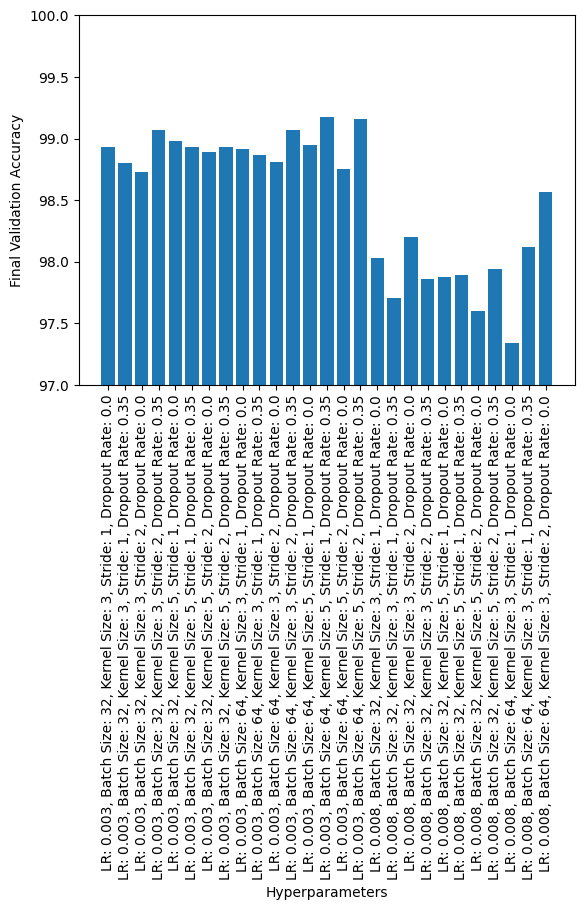

In [39]:
final_train_accuracies = [result['val_acc'] for result in results]
plt.figure()
plt.bar(np.arange(len(final_train_accuracies)), final_train_accuracies)
plt.xticks(np.arange(len(final_train_accuracies)), [f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Kernel Size: {result['kernel_size']}, Stride: {result['stride']}, Dropout Rate: {result['dropout_rate']}" for result in results], rotation=90)
plt.xlabel("Hyperparameters")
plt.ylabel("Final Validation Accuracy")
plt.ylim(97, 100)
plt.tight_layout()
image = wandb.Image(plt)
print(plt)
wandb.log({"Final Validation Accuracies plot": image})
wandb.finish()

In [50]:
# sort the results on the basis of validation accuracy
results = sorted(results, key=lambda x: x['val_acc'], reverse=True)
# train the model on best parameters and evaluate on test_loader
best_result = results[0]
model = CNNModel()
train_loader = DataLoader(mnist_train, batch_size=best_result['batch_size'], shuffle=True)
test_loader = DataLoader(mnist_val, batch_size=best_result['batch_size'], shuffle=False)
epochs = 7

model.setDropout(best_result['dropout_rate'])
model.setLearningRate(best_result['lr'])
model.setKernel(best_result['kernel_size'])
model.setStride(best_result['stride'])
model.setBatchSize(best_result['batch_size'])

train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, test_loader, epochs, best_result['lr'])
confusion_mat = calculate_confusion_matrix(model, test_loader)
class_metrics = calculate_class_metrics(confusion_mat)
print(confusion_mat)
print(class_metrics)

Epoch 1/7 - Train Loss: 0.1720, Train Acc: 94.65%, Val Loss: 0.0441, Val Acc: 98.49%
Epoch 2/7 - Train Loss: 0.0710, Train Acc: 97.83%, Val Loss: 0.0357, Val Acc: 98.79%
Epoch 3/7 - Train Loss: 0.0534, Train Acc: 98.26%, Val Loss: 0.0292, Val Acc: 99.18%
Epoch 4/7 - Train Loss: 0.0470, Train Acc: 98.49%, Val Loss: 0.0375, Val Acc: 98.79%
Epoch 5/7 - Train Loss: 0.0431, Train Acc: 98.63%, Val Loss: 0.0319, Val Acc: 99.06%
Epoch 6/7 - Train Loss: 0.0371, Train Acc: 98.84%, Val Loss: 0.0270, Val Acc: 99.18%
Epoch 7/7 - Train Loss: 0.0368, Train Acc: 98.82%, Val Loss: 0.0284, Val Acc: 99.14%
[[ 975    0    0    0    0    1    3    0    0    1]
 [   0 1132    1    1    0    0    0    1    0    0]
 [   1    1 1025    0    1    0    0    4    0    0]
 [   0    0    2 1002    0    4    0    1    1    0]
 [   0    1    0    0  979    0    0    0    0    2]
 [   0    0    0    9    0  882    1    0    0    0]
 [   3    3    0    0    2    1  948    0    1    0]
 [   0    2    5    0    1    0   

### Noisy MNIST Training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import scipy.io
import numpy as np
from sklearn.metrics import classification_report

mnist_with_awgn = scipy.io.loadmat('mnist-with-awgn.mat')
x_train = mnist_with_awgn['train_x']
y_train = mnist_with_awgn['train_y']
x_test = mnist_with_awgn['test_x']
y_test = mnist_with_awgn['test_y']

def split_data(data, labels, train_size):
    total_size = len(data)
    train_end = int(train_size * total_size)

    x_train = data[:train_end]
    y_train = labels[:train_end]
    x_val = data[train_end:]
    y_val = labels[train_end:]

    return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = split_data(x_train, y_train, 0.8)

x_train, y_train, x_val, y_val, x_test, y_test = map(torch.tensor, (x_train, y_train, x_val, y_val, x_test, y_test))

# convert one hot encoded labels to class labels
y_train = torch.argmax(y_train, dim=1)
y_test = torch.argmax(y_test, dim=1)
y_val = torch.argmax(y_val, dim=1)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [79]:
model = CNNModel()
learning_rate = 0.0008
batch_size = 64
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, train_scores, val_scores = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float().view(inputs.size(0), 1, 28, 28)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_scores.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val, total_val = 0, 0

    for inputs, labels in val_loader:
        inputs = inputs.float().view(inputs.size(0), 1, 28, 28)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_scores.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/15 - Train Loss: 0.5540, Train Acc: 85.52%, Val Loss: 0.1485, Val Acc: 95.75%
Epoch 2/15 - Train Loss: 0.1702, Train Acc: 94.60%, Val Loss: 0.1568, Val Acc: 94.95%
Epoch 3/15 - Train Loss: 0.1336, Train Acc: 95.56%, Val Loss: 0.1061, Val Acc: 96.62%
Epoch 4/15 - Train Loss: 0.1063, Train Acc: 96.56%, Val Loss: 0.0970, Val Acc: 96.86%
Epoch 5/15 - Train Loss: 0.0947, Train Acc: 96.88%, Val Loss: 0.0987, Val Acc: 97.10%
Epoch 6/15 - Train Loss: 0.0819, Train Acc: 97.27%, Val Loss: 0.0845, Val Acc: 97.32%
Epoch 7/15 - Train Loss: 0.0762, Train Acc: 97.51%, Val Loss: 0.0876, Val Acc: 97.56%
Epoch 8/15 - Train Loss: 0.0671, Train Acc: 97.81%, Val Loss: 0.0890, Val Acc: 97.47%
Epoch 9/15 - Train Loss: 0.0643, Train Acc: 97.83%, Val Loss: 0.0989, Val Acc: 97.42%
Epoch 10/15 - Train Loss: 0.0587, Train Acc: 98.04%, Val Loss: 0.1002, Val Acc: 97.10%
Epoch 11/15 - Train Loss: 0.0535, Train Acc: 98.22%, Val Loss: 0.0857, Val Acc: 97.61%
Epoch 12/15 - Train Loss: 0.0512, Train Acc: 98.32%,

In [85]:
model.eval()
correct_test, total_test = 0, 0
all_labels, all_predictions = [], []

for inputs, labels in test_loader:
    inputs = inputs.float().view(inputs.size(0), 1, 28, 28)
    outputs = model(inputs)
    val_, predicted_ = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted_ == labels).sum().item()
    all_labels.extend(labels)
    all_predictions.extend(predicted_)

test_accuracy = round(100 * correct_test / total_test)
print(f"Test Accuracy: {test_accuracy}%")

class_names = [str(i) for i in range(10)]
report = classification_report(all_labels, all_predictions, target_names=class_names)
print(report)

Test Accuracy: 98%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.96      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Autoencoder Implementation

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import scipy.io
import numpy as np
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(autoencoder, dataloader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        
        for inputs, _ in dataloader:
            optimizer.zero_grad()
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the input
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(dataloader)
        print(f"Autoencoder Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}")


In [ ]:
mnist_with_awgn = scipy.io.loadmat('mnist-with-awgn.mat')
x_train = mnist_with_awgn['train_x']
y_train = mnist_with_awgn['train_y']
x_test = mnist_with_awgn['test_x']
y_test = mnist_with_awgn['test_y']

def split_data(data, labels, train_size):
    total_size = len(data)
    train_end = int(train_size * total_size)

    x_train = data[:train_end]
    y_train = labels[:train_end]
    x_val = data[train_end:]
    y_val = labels[train_end:]
    return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = split_data(x_train, y_train, 0.8)

x_train = x_train.astype('float32')  
x_train /= 255.0
x_val = x_val.astype('float32')  
x_val /= 255.0
x_test = x_test.astype('float32')  
x_test /= 255.0

x_train, y_train, x_val, y_val, x_test, y_test = map(torch.tensor, (x_train, y_train, x_val, y_val, x_test, y_test))

y_train = torch.argmax(y_train, dim=1)
y_test = torch.argmax(y_test, dim=1)
y_val = torch.argmax(y_val, dim=1)

noise_factor = 0.05
x_train_noisy = x_train + noise_factor * np.random.normal(0, 1, x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(0, 1, x_test.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(0, 1, x_val.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

batch_size = 64

clean_train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int64))
noisy_train_dataset = TensorDataset(torch.tensor(x_train_noisy, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int64))
clean_train_loader = DataLoader(clean_train_dataset, batch_size=batch_size, shuffle=False)
noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=False)

clean_test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64))
noisy_test_dataset = TensorDataset(torch.tensor(x_test_noisy, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64))
clean_test_loader = DataLoader(clean_test_dataset, batch_size=batch_size, shuffle=False)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)

clean_val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.int64))
noisy_val_dataset = TensorDataset(torch.tensor(x_val_noisy, dtype=torch.float32), torch.tensor(y_val, dtype=torch.int64))
clean_val_loader = DataLoader(clean_val_dataset, batch_size=batch_size, shuffle=False)
noisy_val_loader = DataLoader(noisy_val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
autoencoder = Autoencoder()
autoencoder_learning_rate = 0.0009
autoencoder_epochs = 20

train_autoencoder(autoencoder, noisy_train_loader, autoencoder_epochs, autoencoder_learning_rate)

Autoencoder Epoch 1/20 - Loss: 0.0659
Autoencoder Epoch 2/20 - Loss: 0.0531
Autoencoder Epoch 3/20 - Loss: 0.0497
Autoencoder Epoch 4/20 - Loss: 0.0479
Autoencoder Epoch 5/20 - Loss: 0.0471
Autoencoder Epoch 6/20 - Loss: 0.0465
Autoencoder Epoch 7/20 - Loss: 0.0461
Autoencoder Epoch 8/20 - Loss: 0.0458
Autoencoder Epoch 9/20 - Loss: 0.0456
Autoencoder Epoch 10/20 - Loss: 0.0454
Autoencoder Epoch 11/20 - Loss: 0.0454
Autoencoder Epoch 12/20 - Loss: 0.0453
Autoencoder Epoch 13/20 - Loss: 0.0452
Autoencoder Epoch 14/20 - Loss: 0.0452
Autoencoder Epoch 15/20 - Loss: 0.0452
Autoencoder Epoch 16/20 - Loss: 0.0451
Autoencoder Epoch 17/20 - Loss: 0.0451
Autoencoder Epoch 18/20 - Loss: 0.0450
Autoencoder Epoch 19/20 - Loss: 0.0450
Autoencoder Epoch 20/20 - Loss: 0.0449


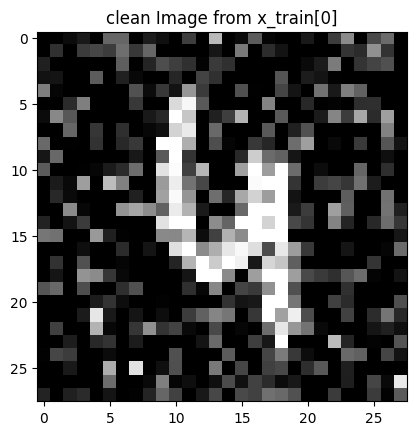

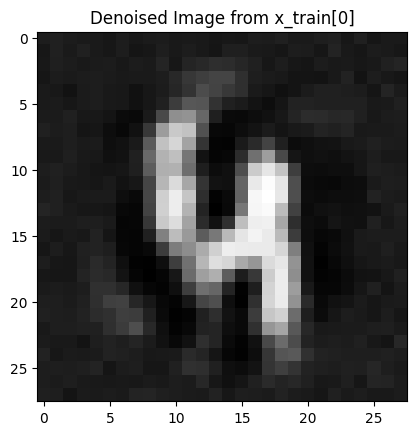

In [48]:
import copy 

def denoise_dataset(autoencoder, dataset_cp):
    autoencoder.eval()
    dataset = copy.deepcopy(dataset_cp)
    denoised_data = []
    with torch.no_grad():
        for inputs, labels in dataset:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the input
            encoded = autoencoder.encoder(inputs)  # Encode the data
            denoised_images = autoencoder.decoder(encoded)  # Decode the encoded data
            denoised_data.append(denoised_images)
    return denoised_data

denoised_train_data = denoise_dataset(autoencoder, clean_train_loader)
denoised_train_data = torch.cat(denoised_train_data, dim=0)

denoised_train_dataset = TensorDataset(denoised_train_data, y_train)
denoised_train_loader = DataLoader(denoised_train_dataset, batch_size=batch_size, shuffle=True)

image_vector = clean_train_dataset[0][0] / 255.0  # Normalize the pixel values
image_matrix = image_vector.reshape(28, 28)
plt.imshow(image_matrix, cmap='gray')
plt.title("clean Image from x_train[0]")
plt.show()

image_vector = denoised_train_dataset[0][0] / 255.0  # Normalize the pixel values
image_matrix = image_vector.reshape(28, 28)
plt.imshow(image_matrix, cmap='gray')
plt.title("Denoised Image from x_train[0]")
plt.show()

## Visualising feature space before denoising

/var/folders/sn/n87ls2012hz6l2qdynmyh12h0000gn/T/ipykernel_29186/3046163443.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('viridis', 10))


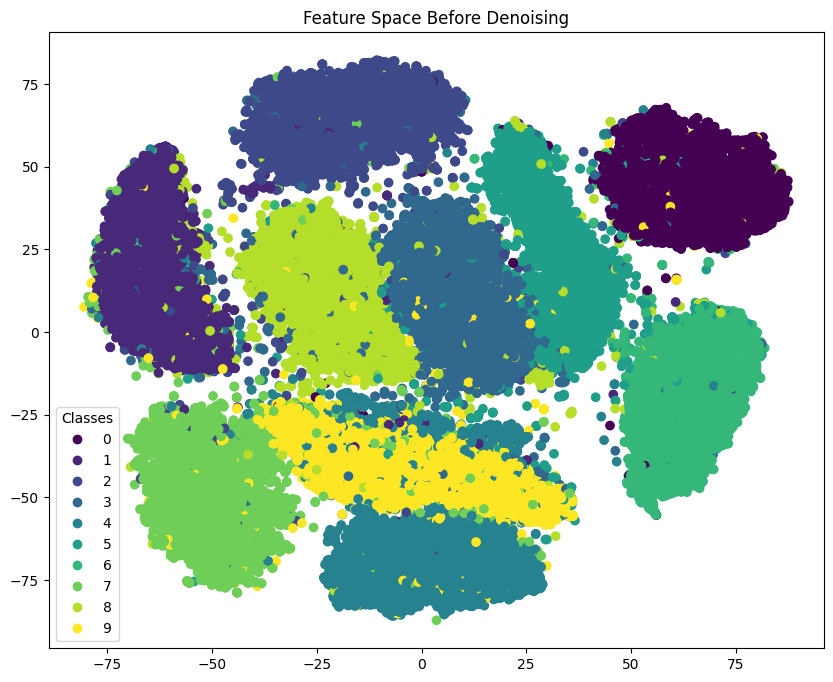

In [108]:
def visualize_feature_space(loader, model, title):
    features = []
    labels_ = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.float().view(inputs.size(0), 1, 28, 28)
            encoded = model.encoder(inputs)
            encoded = encoded.view(encoded.size(0), -1)
            features.append(encoded)
            labels_.append(labels)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels_, dim=0)

    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('viridis', 10))
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.show()

visualize_feature_space(noisy_train_loader, autoencoder, "Feature Space Before Denoising")

/var/folders/sn/n87ls2012hz6l2qdynmyh12h0000gn/T/ipykernel_10651/1877079052.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('viridis', 10))


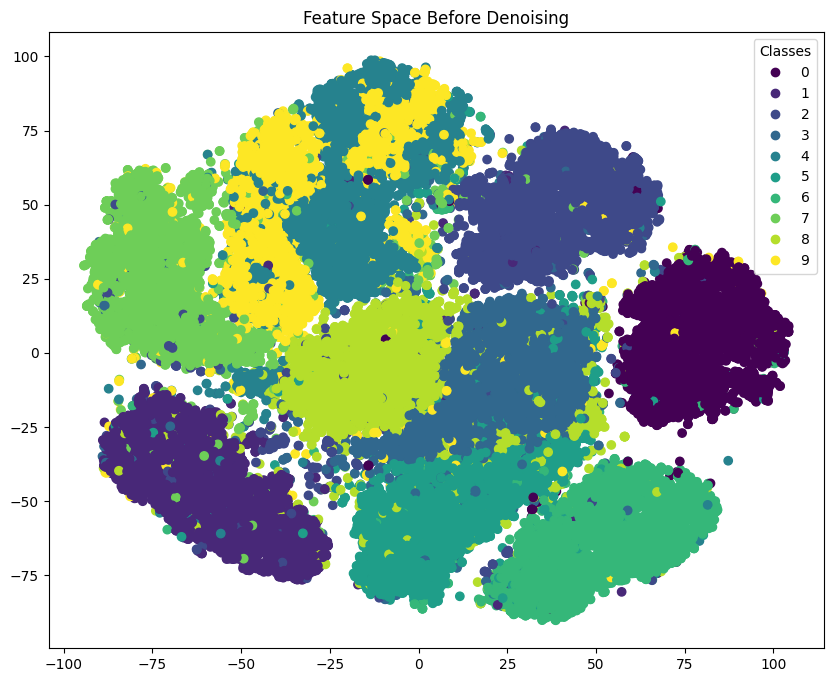

In [10]:
def visualize_feature_space(loader, model, title):
    features = []
    labels_ = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.float().view(inputs.size(0), -1)
            encoded = model.encoder(inputs)
            encoded = encoded.view(encoded.size(0), -1)
            features.append(encoded)
            labels_.append(labels)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels_, dim=0)

    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('viridis', 10))
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.show()

visualize_feature_space(noisy_train_loader, autoencoder, "Feature Space Before Denoising")

## Feature Maps: Visualizing the output of the encoder

#### The extracted features and labels for all batches are concatenated into two large tensors. One tensor holds all the features, and the other holds all the labels.

1) t-SNE Dimensionality Reduction: t-SNE is applied to the concatenated features tensor to reduce its dimensionality to 2D. t-SNE is a dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in 2D or 3D while preserving the relationships between data points.
Plotting:

2) Finally, the code uses matplotlib to create a scatter plot of the 2D feature space. 
3) Each point in the plot represents a data point (an image) in the feature space. The color of each point is determined by the corresponding label, which helps visualize the distribution of data points from different classes. 
4) Each point corresponds to an image from the input dataset (noisy training data), and its position in the feature space is determined by the output of the autoencoder's encoder. 
5) Points with similar features (features that the autoencoder has learned to be important for reconstruction) should cluster together. The color of the points represents the corresponding class labels.

### t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that is particularly useful for visualizing high-dimensional data. It aims to preserve the relationships between data points when mapping them to a lower-dimensional space.

### In the context of an autoencoder, the encoder part of the network learns to extract meaningful features from the input data. Visualizing the feature space helps us understand how well the autoencoder is capturing these features and how well the features separate different classes in the data.
### By plotting the data in 2D (using t-SNE), we gain insights into the distribution of features. If the autoencoder has learned meaningful features, we should be seeing distinct clusters in the feature space for different classes which we do, and this can be useful for understanding the quality of the learned representations.

In [49]:
model = CNNModel()
learning_rate = 0.0008
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, train_scores, val_scores = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in denoised_train_loader:
        optimizer.zero_grad()
        inputs = inputs.float().view(inputs.size(0), 1, 28, 28)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_scores.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val, total_val = 0, 0

    for inputs, labels in val_loader:
        inputs = inputs.float().view(inputs.size(0), 1, 28, 28)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_scores.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/15 - Train Loss: 0.3493, Train Acc: 86.36%, Val Loss: 0.9613, Val Acc: 78.31%
Epoch 2/15 - Train Loss: 0.1330, Train Acc: 94.82%, Val Loss: 0.9089, Val Acc: 80.98%
Epoch 3/15 - Train Loss: 0.1025, Train Acc: 95.93%, Val Loss: 0.9905, Val Acc: 82.46%
Epoch 4/15 - Train Loss: 0.0845, Train Acc: 96.62%, Val Loss: 0.5802, Val Acc: 88.93%
Epoch 5/15 - Train Loss: 0.0756, Train Acc: 97.05%, Val Loss: 0.6118, Val Acc: 89.44%
Epoch 6/15 - Train Loss: 0.0674, Train Acc: 97.29%, Val Loss: 0.4353, Val Acc: 92.04%
Epoch 7/15 - Train Loss: 0.0603, Train Acc: 97.51%, Val Loss: 0.4229, Val Acc: 92.70%
Epoch 8/15 - Train Loss: 0.0550, Train Acc: 97.75%, Val Loss: 0.4921, Val Acc: 92.43%
Epoch 9/15 - Train Loss: 0.0521, Train Acc: 97.85%, Val Loss: 0.5091, Val Acc: 92.67%
Epoch 10/15 - Train Loss: 0.0477, Train Acc: 98.09%, Val Loss: 0.5472, Val Acc: 91.75%
Epoch 11/15 - Train Loss: 0.0429, Train Acc: 98.27%, Val Loss: 0.9373, Val Acc: 88.71%
Epoch 12/15 - Train Loss: 0.0397, Train Acc: 98.34%,

In [56]:
model.eval()
correct_test, total_test = 0, 0
all_labels = []
all_predictions = []

for inputs, labels in noisy_test_loader:
    inputs = inputs.float().view(inputs.size(0), 1, 28, 28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()
    all_labels.extend(labels)
    all_predictions.extend(predicted)

test_accuracy = 100 * correct_test / total_test
print(f"Noisy Test Data Accuracy: {test_accuracy:.2f}%")

# Print the classification report
class_names = [str(i) for i in range(10)]
report = classification_report(all_labels, all_predictions, target_names=class_names)
print(report)

Noisy Test Data Accuracy: 97.45%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.99      0.96      0.97       982
           5       0.96      0.98      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.93      0.99      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## Observations:

### The fundamental theory behind these expectations is that autoencoders are designed to capture the underlying structure of the data by encoding and decoding it. However, their effectiveness depends on the level and type of noise in the data. If the noise is relatively mild and the autoencoder has learned a good representation of the data, it can effectively remove the noise. But when the noise level is too high or of a different nature from what the model was trained on, performance can degrade.
### The training accuracy on the denoised data is expected and observed to be high. This is because the autoencoder is trained to reconstruct clean versions of the input data, and it should be very effective at reconstructing the same data it was trained on. The model can essentially memorize the denoised training data.
### Now when validating on clean validation data (without awgn) the model is expected and observed to not perform to the same mark as on the training data. This is because the model has not seen the validation data before and it is not able to reconstruct it as well as the training data but still performs decently well. This is a good sign that the model is not overfitting.
### Now when testing on noisy test data (with awgn) the model is expected and observed to perform well. This is because the model has seen the noisy data pattern (of awgn) before and it is able to reconstruct it well. This is a good sign that the model is able to generalise well to unseen data.

Resources referred: GPT-3.5 and https://www.deeplearningbook.org/contents/autoencoders.html by Ian Goodfellow and Yoshua Bengio and Aaron Courville.